#Load data

Данные с соревнования

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   place_code = "Running in Colab"
   print(place_code)
   from google.colab import drive
   drive.mount('/content/drive')
   # Корневая папка на диске для работы с заданием - которую вы должны создать себе и указать
   os.chdir('/content/drive/Othercomputers/Пресня/AI-Хакатон_2023_Яндекс.Маркет')

else:
  place_code = "NOT in Colab"
  print(place_code)

HOME = os.getcwd()
print(HOME)

Running in Colab
Mounted at /content/drive
/content/drive/Othercomputers/Пресня/AI-Хакатон_2023_Яндекс.Маркет


In [2]:
import json
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
d = {'all':[]}
with open(HOME + '/pictures_market') as infile:
    for line in infile:
        result = json.loads(line)
        d['all'].append(result)

full_df = pd.DataFrame(d['all'])


Выбранные классы

In [4]:
vers = full_df['verdict'].value_counts().index.to_numpy()
print(f'Все классы - {vers}')
print()
infogrf = [1, 2, 3] # ('good_infographics', 'other_infographics', 'bad_infographics')
not_infogrf = [0, 5, 6] #('clean_photo_good_background','clean_photo_bad_background', 'clean_photo_image_background')

print(f'Классы с инфографикой - {vers[infogrf]}')
print(f'Классы без инфографики - {vers[not_infogrf]}')

test_values = list(vers[infogrf]) + list(vers[not_infogrf])
test_keys = np.arange(len(test_values))

# словарь классов
dict_catagory = dict(zip(test_keys, test_values))
dict_catagory

Все классы - ['clean_photo_good_background' 'good_infographics' 'other_infographics'
 'bad_infographics' 'clean_photo_other_background'
 'clean_photo_bad_background' 'clean_photo_image_background']

Классы с инфографикой - ['good_infographics' 'other_infographics' 'bad_infographics']
Классы без инфографики - ['clean_photo_good_background' 'clean_photo_bad_background'
 'clean_photo_image_background']


{0: 'good_infographics',
 1: 'other_infographics',
 2: 'bad_infographics',
 3: 'clean_photo_good_background',
 4: 'clean_photo_bad_background',
 5: 'clean_photo_image_background'}

In [5]:
def getKey(dct,value):
     return [key for key in dct if (dct[key] == value)]

take_verdict = list(dict_catagory.values())
qty = 500
random_state = 187
print(f'Берем по {qty} примеров из {take_verdict} с инфографикой')
print()
train_df = pd.concat([full_df[full_df.verdict.isin(take_verdict)][full_df.verdict == name].sample(qty,
                                                                               random_state = random_state) for name in take_verdict])
train_df.reset_index(drop= True , inplace= True )
train_df['label'] = train_df.verdict.apply(lambda x: getKey(dict_catagory, x)[0])


Берем по 500 примеров из ['good_infographics', 'other_infographics', 'bad_infographics', 'clean_photo_good_background', 'clean_photo_bad_background', 'clean_photo_image_background'] с инфографикой



Переключаемся в папку Final_TF

In [6]:
if os.getenv("COLAB_RELEASE_TAG"):
   place_code = "Running in Colab"
   print(place_code)
   # Корневая папка на диске для работы с заданием - которую вы должны создать себе и указать
   os.chdir('/content/drive/Othercomputers/My_comp/Documents/Colab_notebooks/Notebooks_GoogleDisk/Тестовые работы/GAN_hakaton_23/Final_TF')

else:
  place_code = "NOT in Colab"
  os.chdir('/Final_TF')
  print(place_code)

HOME = os.getcwd()
print(HOME)

from Additions import show_images, data2predict, prompts2seg_classes, enhance_class_name

Running in Colab
/content/drive/Othercomputers/My_comp/Documents/Colab_notebooks/Notebooks_GoogleDisk/Тестовые работы/GAN_hakaton_23/Final_TF


# CLIP

In [7]:
#@title Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-28b02c60-ceea-9085-5adb-10c7ea6bbe96)


In [8]:
#@title Setup Требуется время на загрузку
import os, subprocess
from IPython.display import clear_output

def setup():
    install_cmds = [
        ['pip', 'install', 'gradio'],
        ['pip', 'install', 'open_clip_torch'],
        ['pip', 'install', 'clip-interrogator'],
    ]
    for cmd in install_cmds:
        print(subprocess.run(cmd, stdout=subprocess.PIPE).stdout.decode('utf-8'))

setup()


caption_model_name = 'blip-base' #@param ["blip-base", "blip-large", "git-large-coco"]
clip_model_name = 'ViT-L-14/openai' #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]

import gradio as gr
from clip_interrogator import Config, Interrogator

config = Config()
config.clip_model_name = clip_model_name
config.caption_model_name = caption_model_name
ci = Interrogator(config)

def image_analysis(image):
    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, 5)
    top_artists = ci.artists.rank(image_features, 5)
    top_movements = ci.movements.rank(image_features, 5)
    top_trendings = ci.trendings.rank(image_features, 5)
    top_flavors = ci.flavors.rank(image_features, 5)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}

    return medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks

def image_to_prompt(image, mode):
    ci.config.chunk_size = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)

clear_output()

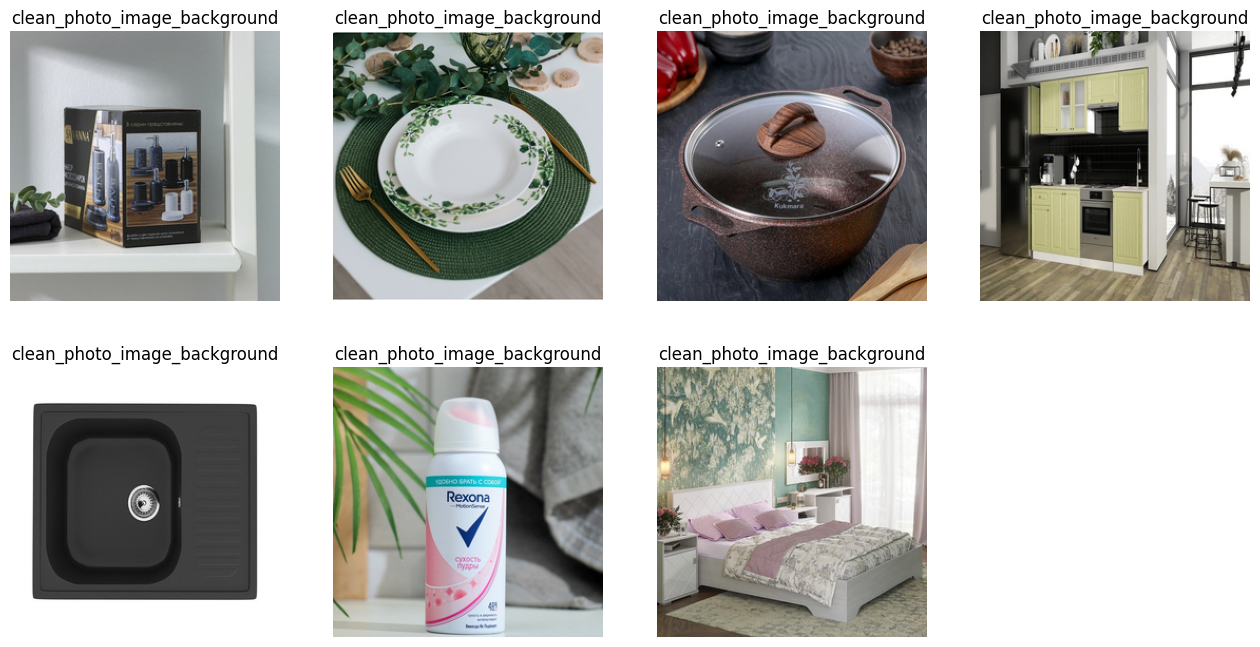

In [75]:
#@title Выбираем verdict и грузим фото

verdict = 'clean_photo_image_background' #@param ['good_infographics', 'other_infographics', 'bad_infographics', 'clean_photo_good_background', 'clean_photo_bad_background', 'clean_photo_image_background']
cls = getKey(dict_catagory, verdict)[0]
mask = train_df.verdict == dict_catagory[cls]
idxs = train_df[mask].sample(7).index

mask = train_df.index.isin(idxs)
urls = train_df.loc[mask].pic_url
labels = train_df.loc[mask].label

W, H =  256, 256
images, _, labels = data2predict(urls = urls,
                     labels = labels,
                     resize2 = (W, H),
                     )
print()
name_cls = list(dict_catagory.values())
show_images(images, labels, name_cls)


# Batch process a folder of images

Generating prompts:   0%|          | 0/7 [00:00<?, ?it/s]

['a white shelf with a black towel and a black towel', ' a still life by Veno Pilon', ' cg society contest winner', ' lyco art', ' high detail product photo', ' detailed product image', ' dark-toned product photos']



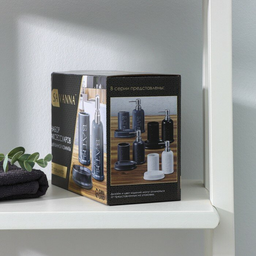

Generating prompts:  14%|█▍        | 1/7 [00:00<00:03,  1.55it/s]

['a table setting with green leaves and gold cutlers', ' a stock photo inspired by Louise Abbéma', ' pinterest contest winner', ' aestheticism', ' green tones and golden charms', ' place setting', ' fine filigree foliage lace']



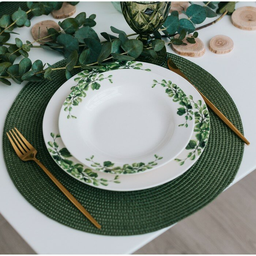

Generating prompts:  29%|██▊       | 2/7 [00:01<00:03,  1.59it/s]

['a wooden spoon', ' a stock photo inspired by Katsukawa Shunkō I', ' cg society contest winner', ' cloisonnism', ' lacquerware', ' japanese collection product', ' tanjiro kamado']



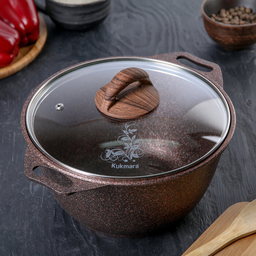

Generating prompts:  43%|████▎     | 3/7 [00:01<00:02,  1.74it/s]

['a kitchen with a stove', ' sink and oven', ' a digital rendering inspired by Richard Rockwell', ' cg society contest winner', ' photorealism', ' 3dcoat h 648', ' pinterest render', ' 3d rendered model']



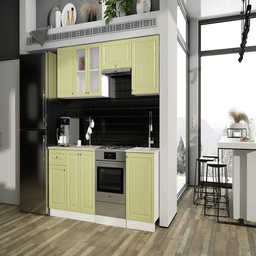

Generating prompts:  57%|█████▋    | 4/7 [00:02<00:01,  1.71it/s]

['a black sink with a drainer and a drainer', ' a digital rendering inspired by Lars Jonson Haukaness', ' polycount', ' photorealism', ' fixing a leaking sink', ' sink', ' ashford black marble']



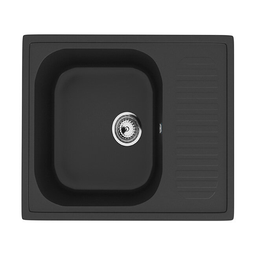

Generating prompts:  71%|███████▏  | 5/7 [00:03<00:01,  1.67it/s]

['rexa spray deod spray on a table', ' a stock photo by Relja Penezic', ' instagram contest winner', ' remodernism', ' full head and shoulders', ' clean face and body skin', ' head and shoulders in frame']



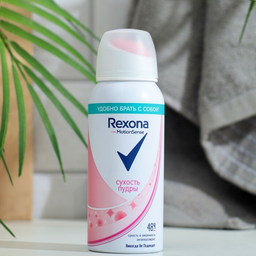

Generating prompts:  86%|████████▌ | 6/7 [00:03<00:00,  1.66it/s]

['a bedroom with a bed and a large painting on the wall', ' a digital rendering inspired by Louise Abbéma', ' behance', ' rococo', ' serene bedroom setting', ' girly bedroom', ' modern pastel colours']



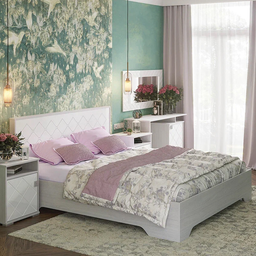

Generating prompts: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


In [76]:
#@title Получаем промты из images
#import csv
import os
from IPython.display import clear_output, display
from PIL import Image
from tqdm import tqdm

prompt_mode = 'classic' #@param ["best","fast","classic","negative"]
max_filename_len = 128 #@param {type:"integer"}


def sanitize_for_filename(prompt: str, max_len: int) -> str:
    name = "".join(c for c in prompt if (c.isalnum() or c in ",._-! "))
    name = name.strip()[:(max_len-4)] # extra space for extension
    return name

ci.config.quiet = True

prompts = []
for idx, image in enumerate(tqdm(images, desc='Generating prompts')):
    if idx > 0 and idx % 100 == 0:
        clear_output(wait=True)
    image = image.convert('RGB')
    prompt = image_to_prompt(image, prompt_mode)
    prompts.append(prompt)

    print(prompt.split(','))
    print()
    thumb = image.copy()
    thumb.thumbnail([256, 256])
    display(thumb)


## Dino and SAM

In [12]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [16]:
#@title Pip models GroundingDINO
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


os.chdir('/content')
HOME = os.getcwd()

%cd {HOME}
!mkdir {HOME}/GroundingDINO
!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd {HOME}/GroundingDINO
!pip install -q -e .

!pip install -q roboflow -q

!pip uninstall -y supervision
!pip install -q supervision==0.6.0

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

import supervision as sv

clear_output()

print(sv.__version__)
print(HOME)

0.6.0
/content


In [17]:
#@title Load models GroundingDINO

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "GroundingDINO", "groundingdino_swint_ogc.pth")#
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

%cd {HOME}/GroundingDINO
from groundingdino.util.inference import Model
grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH,
                             model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content/GroundingDINO/groundingdino_swint_ogc.pth ; exist: True
/content/GroundingDINO
final text_encoder_type: bert-base-uncased


In [77]:
j =  6 # номер картинки
CLASSES = prompts2seg_classes(prompts[j]) # получаем со всех промтов классы к картинке
CLASSES

['bedroom',
 'wall',
 'and',
 'girly',
 'Abbéma',
 'setting',
 'colours',
 'with',
 'pastel',
 'modern',
 'large',
 'Louise',
 'the',
 'bed',
 'inspired',
 'serene',
 'rendering',
 'painting',
 'behance',
 'digital',
 'rococo',
 'infographic',
 'product',
 'packaging']

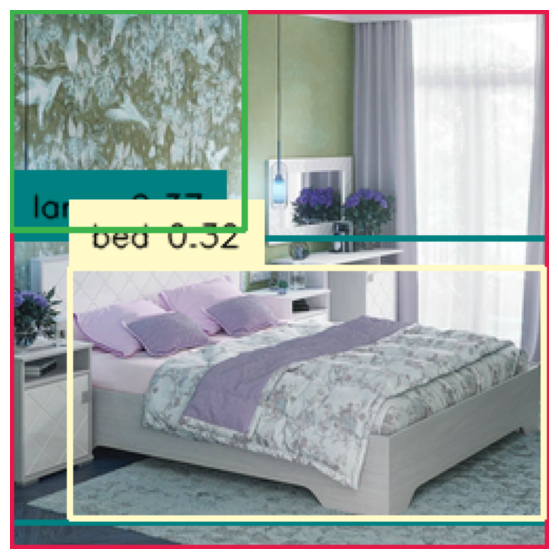

In [78]:
import cv2
import supervision as sv

BOX_TRESHOLD = 0.25
TEXT_TRESHOLD = 0.15

open_cv_image = np.array(images[j].copy())
# Convert RGB to BGR
im = open_cv_image[:, :, 2::-1].copy()


# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=np.array(im),
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=open_cv_image,
                                         detections=detections,
                                         labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (7, 7))

In [20]:
#@title Load segment-anything

%cd {HOME}
!mkdir {HOME}/weights_sam_vit
%cd {HOME}/weights_sam_vit
# ViT-H
!wget -qN https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

!pip install -q git+https://github.com/facebookresearch/segment-anything.git

clear_output()

import numpy as np
from segment_anything import sam_model_registry, SamPredictor

# model_type = 'vit_h'
sam = sam_model_registry["vit_h"](checkpoint= HOME+"/weights_sam_vit/sam_vit_h_4b8939.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam.to(device=device)
sam_predictor = SamPredictor(sam)

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

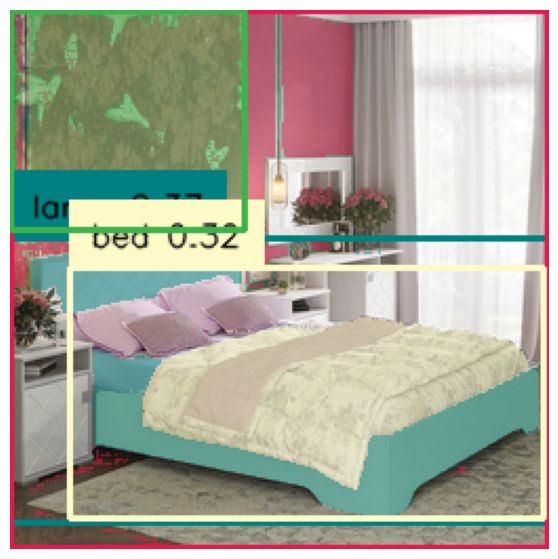

In [79]:
import cv2

open_cv_image = np.array(images[j].copy())
# Convert RGB to BGR
open_cv_image = open_cv_image[:, :, 2::-1].copy()
image_rgb = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB)
im = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)


# convert detections to masks
detections.mask = segment(
    sam_predictor = sam_predictor,
    image=im,
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_image = mask_annotator.annotate(scene=open_cv_image, detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (7, 7))

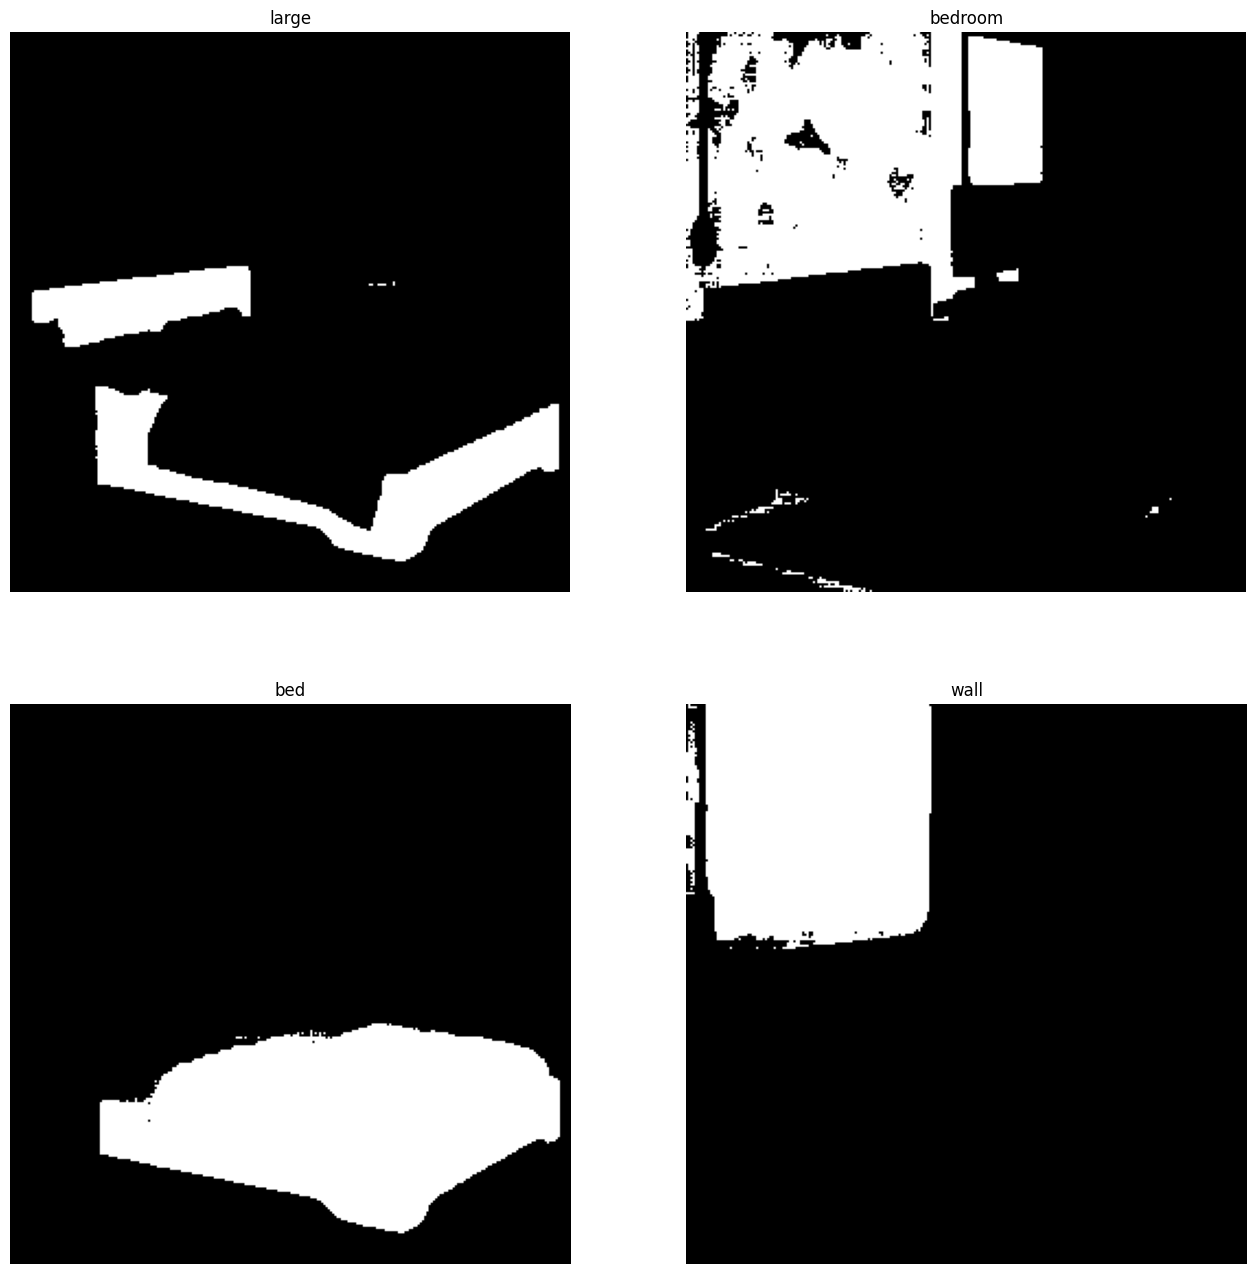

In [80]:
import math

grid_size_dimension = math.ceil(math.sqrt(len(detections.mask)))
if grid_size_dimension ==1 : grid_size = (1,2)
else: grid_size = (grid_size_dimension, grid_size_dimension)

titles = [
    CLASSES[class_id]
    for class_id
    in detections.class_id
]

sv.plot_images_grid(
    images=detections.mask,
    titles=titles,
    grid_size=grid_size,
    size=(16, 16)
)

#### improvment mask

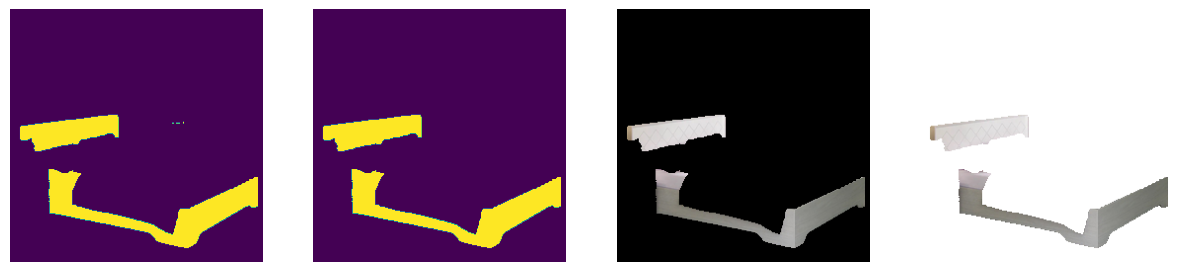

In [81]:
from skimage import morphology
show_masks =[]

best_mask = detections.mask[0].copy()
show_masks.append(best_mask)

clear_best_mask = morphology.remove_small_objects(best_mask,
                                                  min_size=62,
                                                  connectivity=2)
show_masks.append(clear_best_mask)


gray_mask = clear_best_mask.astype(np.uint8)
element = cv2.bitwise_or(image_rgb, image_rgb, mask=gray_mask)
show_masks.append(element)

element = image_rgb.copy()
element[gray_mask<0.5] = [255, 255, 255]
show_masks.append(element)

plt.figure(figsize=(15, 10))
k = len(show_masks)
for i in range(k):
    ax = plt.subplot(1, k, i + 1)
    plt.imshow(show_masks[i])
    plt.axis("off")

# Generation In-painting with Stable Diffusion

In [31]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 5.6 MB/s eta 0:00:00


In [32]:
from huggingface_hub import notebook_login

notebook_login()

In [33]:
#@title Loading SDX
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

safety_checker/model.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [82]:
#@title Choose prompt to  SDX

prompt_sdx = 'image background' #@param  ['good simple background', 'image background', 'solid color background', 'infographics']

pil_mask = PIL.Image.fromarray(clear_best_mask)
invert_mask = PIL.ImageOps.invert(pil_mask)
pil_image = PIL.Image.fromarray(image_rgb)
invert_mask


mask_image = invert_mask.resize((512, 512))
image2sdx =  pil_image.resize((512, 512))


guidance_scale=9.6 #@param {type:"slider", min:3, max:11, step:0.3}
num_samples = 3 #@param {type:"slider", min:1, max:7, step:1}
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

images_sdx = pipe(
    prompt=prompt_sdx,
    image=image2sdx,
    mask_image=mask_image,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [83]:
# insert initial image in the list so we can compare side by side
images_sdx.insert(0, image2sdx)

image_grid(images_sdx, 1, num_samples + 1)

Output hidden; open in https://colab.research.google.com to view.